## Load Dataset

In [127]:
# Import dependencies

from typing import List, Set, Dict
import pandas as pd 
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import torch 
from torch.utils.data import random_split, TensorDataset, DataLoader
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import roc_auc_score, recall_score, roc_curve, precision_score, f1_score, confusion_matrix, accuracy_score
from matplotlib import pyplot as plt
import seaborn as sns; sns.set_theme()

if torch.backends.mps.is_available():
    mps_device=torch.device('mps')
    x=torch.ones(1,device=mps_device)
    print(x)
else:
    print('mps device not found')


tensor([1.], device='mps:0')


In [2]:
# Load dataset
from sklearn.model_selection import train_test_split
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None)
df.columns = ['target', 'id', 'date', 'flag', 'user', 'text']  # Assign column names
df = df[['target', 'text']]  # Keep relevant columns only

# Target values
print(f" target value counts: {df['target'].value_counts()}")

# Map two classes with 0 and 1
df['target']= df['target'].replace({0:0, 4:1})
print(f"mapped target value counts: {df['target'].value_counts()}")

 target value counts: target
0    800000
4    800000
Name: count, dtype: int64
mapped target value counts: target
0    800000
1    800000
Name: count, dtype: int64


## Data cleaning

In [3]:
print(df['text'][:5]) # Top 5 tweets

0    @switchfoot http://twitpic.com/2y1zl - Awww, t...
1    is upset that he can't update his Facebook by ...
2    @Kenichan I dived many times for the ball. Man...
3      my whole body feels itchy and like its on fire 
4    @nationwideclass no, it's not behaving at all....
Name: text, dtype: object


What are irrelevant expressions in tweets? 

- Tags with @ 
- Hashtags
- Links
- Punctuations
- Stopwords (which do not carry any significant meaning) like 'is' 'and' 'the' etc. 

In [4]:
# Remove irrelevant expressions from text

import re
import nltk  # To download predefined list of stopwords 
from nltk.corpus import stopwords 

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text: str)-> str:
    text = text.lower()  # Lowercase
    text = re.sub(r'@\w+', '', text)  # Remove tags with @ i.e. mentions
    # text = re.sub(r'#', '', text)  # Remove hashtags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove links
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuations (all other than words and space chars)
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stop words
    return text

df['text']= df['text'].apply(clean_text)  # Apply regex on text col
# isinstance(df['text'][0], str) # To check if our type attribute is correct

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tanukhanuja/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Tokenization 

In [5]:
# Define a token function
def tokenize(text:str) -> List[str]:
    return text.split()  # Split the sentences at any whitespaces (default)

df['tokens'] = df['text'].apply(tokenize) # Create a new column of tokens list
print(df.head(3))

   target                                               text  \
0       0      thats bummer shoulda got david carr third day   
1       0  upset cant update facebook texting might cry r...   
2       0  dived many times ball managed save 50 rest go ...   

                                              tokens  
0  [thats, bummer, shoulda, got, david, carr, thi...  
1  [upset, cant, update, facebook, texting, might...  
2  [dived, many, times, ball, managed, save, 50, ...  


## Vocabulary creation

In [6]:
unique_tokens:Set[str] = set([token for tokens in df['tokens'] for token in tokens]) # Create a set of unique tokens
special_tokens = ["<pad>", "<unk>"] # Tokens to set fix length of sequences and to represent words not present in unique token list(vocabulary)
vocab: Dict[str, int] = {word: i for i, word in enumerate(special_tokens+list(unique_tokens))} # Assign token id to unique tokens 

print(f" Vocab list length: {len(vocab.items())}")

 Vocab list length: 447915


In [7]:
# Create a new column of encoded token lists for each row based on vocab id

def encode_tokens(tokens: List[str], vocab: Dict[str, int])-> List[int]:
    return [vocab.get(word, vocab['<unk>']) for word in tokens] 

df['tokens_id_encoded'] = [encode_tokens(tokens, vocab) for tokens in df['tokens']]

In [8]:
l: List[int] = [len(d) for d in df['tokens_id_encoded']] # Lengths of each token
quantile = np.quantile(np.array(l), 0.95) # 95% of tokens have length under this
print(f"{quantile=}")

quantile=np.float64(15.0)


- We can see that the encoded token are of different lengths due to different tweet lengths. But when we feed these tokens to NN, the shape of their tensors should be same. For this we perform padding of 0s on the tokens to set a fix length to each tensor.

- Here we will set:
  - fix len of a token is 15.
  - If sentence is short, add padding tokens to match the fix len.
  - If sentence is long, truncate extra tokens to fix len.

## Padding

In [9]:
def padding(encoded_token: List[int], fix_len: int = 25) -> List[int]:
        """ 
        Add paddings to encoded_tokens to set a fix length of each token lists to fix_len.
        """
        if len(encoded_token) < fix_len:
            padded_token = encoded_token + [vocab['<pad>']]*(fix_len-len(encoded_token))
        else:
            padded_token = encoded_token[:fix_len]
        return padded_token

df['padded_tokens'] = df['tokens_id_encoded'].apply(padding)

In [10]:
# Convert the padded_tokens and target columns into PyTorch tensor with 64-bit integer type (torch.long), ready for model input.
input_tensor = torch.tensor(df['padded_tokens'].tolist(), dtype= torch.long) # Convert shape of tensor to (sample_size, seq_len)
output_tensor = torch.tensor(df['target'].tolist(), dtype=torch.float32).unsqueeze(-1) # Convert shape of output tensor to (sample_size,1)

print(f"{input_tensor.shape=}")
print(f"{output_tensor.shape=}")

input_tensor.shape=torch.Size([1600000, 25])
output_tensor.shape=torch.Size([1600000, 1])


## Split data to train, val, test

In [11]:
dataset = TensorDataset(input_tensor, output_tensor) # Wraps input and output tensors into tuples (input_tensor[i], output_tensor[i])

# Define split sizes
total_samples = len(dataset)
train_len = int(0.8*total_samples)
val_len = int(0.1*total_samples)
test_len = total_samples-train_len-val_len

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_len, val_len, test_len])

## Create dataloaders

In [12]:
batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False)

In [13]:
for x, y in train_loader:
    print(f"{x.shape=}")  #(batch_size, seq_len)
    print(f"{y.shape=}")  #(batch_size,1)
    break

x.shape=torch.Size([1024, 25])
y.shape=torch.Size([1024, 1])


## LSTM model 

- We have training tensors in batch sizes. But the tensor values are nothing but indices of vocab.
  
- These indices needs to be converted to embeddings i.e. dense semantic vectors. This is done by embedding method in nn module.
  
- nn.Embedding will first create the matrix of vectors for each vocabulary. We need to give common size of the embedding vectors i.e. embedding_dim.
  
- This will convert the input tensor dimension to (batch_size, seq_len, embedding_dim).

In [14]:
# Initialize derived sequential class of nn layer base class

class LSTMModel(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, hidden_dim: int, output_dim: int, dropout=0.5) -> None:
        """ 
        vocab_size: To define number of rows in embedding matrix.
        embedding_dim: Size of embedding vector
        hidden_dim: Number of features in LSTM hidden state.
        output_dim: Number of classes (1 for binary/regression)
        num_layers: Number of LSTM layers.
        dropout: dropout rate applied between LSTM layers(defualt is no dropout)
        """
        super(LSTMModel, self).__init__()

        self.embeddings = nn.Embedding(num_embeddings=vocab_size, 
                                       embedding_dim=embedding_dim, 
                                       padding_idx=0)  # Convert token indices to embeddings.
        self.dropouts = nn.Dropout()
        
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_dim,
                            batch_first = True,
                            )  # Process sequence of embeddings.
                               # batch_first ensures the shape of input as (batch_size, seq_len, embedding_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim) # Fully connected layer to map hidden state of lstm layer to output.
        self.sigmoid = nn.Sigmoid() # For binary classification

    def forward(self, x):
        """ 
        x: Tensor of shape (batch_size, seq_len) (before embedding)
        """
        embedded = self.embeddings(x) # Convert tokens indices to embeddings
        dropouts = self.dropouts(embedded)
        lstm_out,_ = self.lstm(dropouts) # Pass embedding through lstm
        output = self.fc(lstm_out[:,-1]) # Use final hidden state from last lstm layer

        return self.sigmoid(output)



In [15]:
# Train model

vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = 1

model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim)
print(model)

LSTMModel(
  (embeddings): Embedding(447915, 300, padding_idx=0)
  (dropouts): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(300, 300, batch_first=True)
  (fc): Linear(in_features=300, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [16]:

criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# scheduler = StepLR(optimizer, step_size=3, gamma=0.5) # Reduce LR by 0. every 5 epochs


num_epochs = 10

for epoch in range(num_epochs):
    total_loss = 0
    model.train()
    for texts, labels in train_loader:
        # print(texts.shape)
        texts, labels = texts.to(dtype=torch.long), labels.to(dtype=torch.float32)
        optimizer.zero_grad()
        outputs = model(texts)
        # print(outputs.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    # scheduler.step()
    avg_loss = total_loss/len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}, Epoch Loss: {loss.item():.4f}")

    # Validation loop
    model.eval()
    with torch.no_grad():
        val_loss=0
        for texts, labels in val_loader:
            texts, labels = texts.to(dtype= torch.long), labels.to(dtype=torch.float32)
            outputs = model(texts)
            loss = criterion(outputs,labels)
            val_loss +=loss.item()
    avg_val_loss = val_loss/len(val_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average validation loss:  {avg_val_loss:.4f}, Epoch val loss: {loss.item():.4f}") 

Epoch 1/10, Average Loss: 0.5217, Epoch Loss: 0.4450
Epoch 1/10, Average validation loss: 0.4846, Epoch val loss: 0.5164
Epoch 2/10, Average Loss: 0.4733, Epoch Loss: 0.4666
Epoch 2/10, Average validation loss: 0.4657, Epoch val loss: 0.5156
Epoch 3/10, Average Loss: 0.4554, Epoch Loss: 0.4671
Epoch 3/10, Average validation loss: 0.4494, Epoch val loss: 0.5061
Epoch 4/10, Average Loss: 0.4422, Epoch Loss: 0.4676
Epoch 4/10, Average validation loss: 0.4416, Epoch val loss: 0.4792
Epoch 5/10, Average Loss: 0.4319, Epoch Loss: 0.4141
Epoch 5/10, Average validation loss: 0.4479, Epoch val loss: 0.5027
Epoch 6/10, Average Loss: 0.4230, Epoch Loss: 0.4077
Epoch 6/10, Average validation loss: 0.4349, Epoch val loss: 0.4747
Epoch 7/10, Average Loss: 0.4151, Epoch Loss: 0.3973
Epoch 7/10, Average validation loss: 0.4319, Epoch val loss: 0.4736
Epoch 8/10, Average Loss: 0.4086, Epoch Loss: 0.4164
Epoch 8/10, Average validation loss: 0.4320, Epoch val loss: 0.4755
Epoch 9/10, Average Loss: 0.4016

ROC_AUC score: 0.8834335105596592
Recall: 0.7901172822526195
Precision: 0.8078132590187406
F1 score: 0.7988672852772369
Accuracy: 0.801125


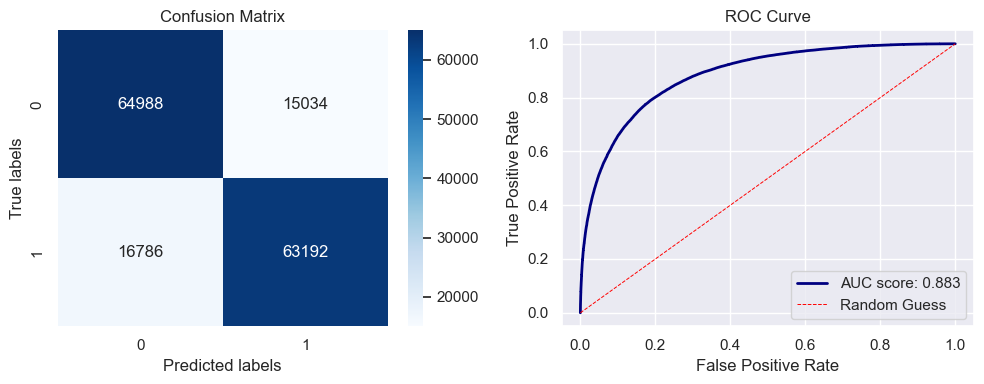

In [145]:
# Metrics calculations using test data
prediction_probs = []
prediction_list = []
true_labels = []

model.eval()  # Set model on evaluation mode first
with torch.no_grad():
    for texts,labels in test_loader:
        true_labels.extend(labels.squeeze().detach().numpy()) # Convert tensor to numpy array using detach().numpy()

        outputs = model(texts)
        prediction_probs.extend(outputs.squeeze().detach().numpy())
        
        predicted = (outputs>0.5).float()
        prediction_list.extend(predicted.squeeze().detach().numpy())

# Calculate and print all metrics
roc_auc = roc_auc_score(true_labels,prediction_probs) 
recall = recall_score(true_labels, prediction_list)
precision = precision_score(true_labels, prediction_list)
f1 = f1_score(true_labels, prediction_list)
accuracy = accuracy_score(true_labels, prediction_list)
print(f"ROC_AUC score: {roc_auc.item()}\nRecall: {recall.item()}\nPrecision: {precision.item()}\nF1 score: {f1.item()}\nAccuracy: {accuracy}")

# Create confusion matrix and roc-auc curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4)) # Create a single figure with 1 row and 2 columns

# Plot confusion matrix on the left subplot (ax1)
cnf_matrix = confusion_matrix(true_labels, prediction_list)
sns.heatmap(cnf_matrix, cmap='Blues', annot=True, fmt='d', ax=ax1)
ax1.set_xlabel('Predicted labels')
ax1.set_ylabel('True labels')
ax1.set_title('Confusion Matrix')

# Plot ROC-AUC curve on the right subplot (ax2)
fpr, tpr, thresholds = roc_curve(true_labels, prediction_probs)
ax2.plot(fpr, tpr, color='navy', lw=2, label=f'AUC score: {roc_auc:.3f}')
ax2.plot([0, 1], [0, 1], color='red', linestyle='--', lw=0.7, label='Random Guess')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')
ax2.legend(loc='lower right')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [182]:
def predict_sentiment(tweet: str)-> str:
    cleaned_tweet = clean_text(tweet) # Clean tweet using regex func
    tokens = tokenize(cleaned_tweet)  # Tokenize
    encoded_tokens = encode_tokens(tokens, vocab) # Encode on vocab ids
    padded_tokens = padding(encoded_tokens, fix_len=25) # Pad the seq
    input_tensor = torch.tensor([padded_tokens], dtype=torch.long) # Convert to tensor

    model.eval() # Set the model to evaluation mode
    with torch.no_grad(): # Predict
        output = model(input_tensor)
        prediction = output.item()  # Get the prediction probability

    # Determine if the tweet is positive or negative
    threshold = 0.5 
    if prediction >= threshold:
        sentiment = "Positive"
    else:
        sentiment = "Negative"

    print(f"tweet: {tweet}, Predicted sentiment: {sentiment} (Probability: {prediction:.4f})")


In [185]:
tweets = [
    "I absolutely love this product! It has made my life so much easier. Highly recommend it!",
    "The service at this restaurant was amazing. The staff was friendly, and the food was delicious!",
    "I'm really disappointed with the customer service. They were rude and unhelpful.",
    "The food was terrible, and the place was dirty. I wouldn't recommend it to anyone.",
    "This is exactly how I wanted to spend my weekend—fixing someone else's mistakes.",
    "The weather is perfect... if you enjoy being drenched in rain.",
    "This is exactly how I wanted to spend my weekend—fixing someone else's mistakes.",
    "Oh great, another delay. Just what I needed today!",
    "Wow, this product is amazing... said no one ever.",
    "I love waiting in line for hours. Such a fantastic experience!"
]

sentiment = {}
for tweet in tweets:
    sentiment[tweet]= predict_sentiment(tweet)

tweet: I absolutely love this product! It has made my life so much easier. Highly recommend it!, Predicted sentiment: Positive (Probability: 0.9886)
tweet: The service at this restaurant was amazing. The staff was friendly, and the food was delicious!, Predicted sentiment: Positive (Probability: 0.9846)
tweet: I'm really disappointed with the customer service. They were rude and unhelpful., Predicted sentiment: Negative (Probability: 0.0049)
tweet: The food was terrible, and the place was dirty. I wouldn't recommend it to anyone., Predicted sentiment: Negative (Probability: 0.1202)
tweet: This is exactly how I wanted to spend my weekend—fixing someone else's mistakes., Predicted sentiment: Negative (Probability: 0.1884)
tweet: The weather is perfect... if you enjoy being drenched in rain., Predicted sentiment: Positive (Probability: 0.5880)
tweet: This is exactly how I wanted to spend my weekend—fixing someone else's mistakes., Predicted sentiment: Negative (Probability: 0.1884)
tweet: